# **Space X  Falcon 9 First Stage Landing Prediction**


Estimated time needed: **60** minutes


**`SpaceX`** advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because SpaceX can **reuse the first stage**.

>*Therefore if we can determine **if the first stage will land**, we can determine the **cost of a launch**.*

This information can be used if an alternate company wants to **bid against SpaceX** for a rocket launch.

>In this lab, you will create a **machine learning pipeline**  to predict if the **first stage will land** given the data from the preceding labs.

Example of a **successful launch** $\rightarrow$

![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/landing_1.gif)


Example of an **unsuccessful launch** $\rightarrow$

![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/crash.gif)


**NOTE**: Most unsuccessful landings are planned. Space X performs a controlled landing in the oceans. 

---

## Objectives


1. Perform **Exploratory  Data Analysis** and determine **Training Labels**
    - create a column for the class
    - Standardize the data
2. Split into **training data** and **test data**
3. Find best **Hyperparameter** for $\rightarrow$
    - `SVM`
    - `Classification Trees`
    - `Logistic Regression`
    - `KNN Classifier`
4. Find **best method and machine learning model** using `test data`

---

## Import Libraries and Define Auxiliary Functions


In [1]:
# import piplite
# await piplite.install(['numpy'])
# await piplite.install(['pandas'])
# await piplite.install(['seaborn'])

### Dependencies

In [1]:
# for data manipulation
import pandas as pd
# for numerical computing & array manipulations
import numpy as np
# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
# for preparing data for machine learning 
from sklearn import preprocessing ## data standardization
from sklearn.model_selection import train_test_split ## creating training & test set
from sklearn.model_selection import GridSearchCV ## finding best hyperparameters
from sklearn.linear_model import LogisticRegression ## Logistic Regression classifier model
from sklearn.svm import SVC ## SVM model
from sklearn.tree import DecisionTreeClassifier ## Classification Tree model
from sklearn.neighbors import KNeighborsClassifier ## KNN Classifier model

### Helper functions

In [2]:
def custom_confusion_matrix(y_true, y_pred,
                           normalize, model_name):
    """
    Plots a Confusion Matrix for the
    SpacEx Falcon 9 landing dataset
    to visualize performance of the classifer model.
    
    Parameters ->
    `y_true`: True values (ground truth) of target variable
    `y_pred`: Predictions by the classifier model
    `normalize`: (bool) If True, confusion matrix values will be normalized
    `model_name`: Name of ML classifier for which confusion matrix is being plotted
    
    CONFUSION MATRIX (`cm`) for BINARY CLASSIFICATION ->
        * Rows: True labels
        * Columns: Predicted labels
        
                `cm[0,0]` = True Negatives
                `cm[0,1]` = False Positives
                `cm[1,0]` = False Negatives
                `cm[1,1]` = True Positives
    
    """
    # DEPENDENCIES
    from sklearn.metrics import confusion_matrix
    import numpy as np
    
    # create confusion matrix object
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    
    # NORMALIZING THE CONFUSION MATRIX
    if normalize:
        # normalize the rows of confusion matrix & print it
        cm = cm.astype(float) / (cm.sum(axis=1)).reshape(-1,1)
        print(f"Normalized Confusion Matrix ->\n{cm}")
    
    else:
        # print un-normalized confusion matrix
        print(f"Confusion Matrix (without normalization) ->\n{cm}")
    
    
    # PLOT CONFUSION MATRIX
    
    fig, ax = plt.subplots(figsize=(4,4), dpi=250)
    
    # customizations
        ## font
    axis_fonts = dict(family="times new roman", size=9, weight="bold")
    title_font = dict(family="times new roman", size=10)
    tick_font = dict(family="times new roman", size=8)
        ## cmap colors
    colors = ["#CDFADB", "#F6FDC3", "#C63D2F"]
    
    sns.heatmap(data=cm, ax=ax, annot=True,
               cmap="Blues")
    
    ax.set_xlabel("Predicted Labels", fontdict=axis_fonts)
    ax.set_ylabel("True Labels", fontdict=axis_fonts)
    
    ax.xaxis.set_ticklabels(["Failed to Land", "Success"], fontdict=tick_font)
    ax.yaxis.set_ticklabels(["Failed to Land", "Success"], fontdict=tick_font)
    ax.tick_params(axis="both", length=0)
    
    
    ax.set_title(f"Confusion Matrix ({model_name})",
                fontdict=title_font)
    
    fig.tight_layout();

## Load the dataset as `pandas` DataFrame

#### NOTE
>The datasets are the same ones which were analyzed, cleaned, and processed in previous notebooks.
1. `dataset_part_2.csv` $\rightarrow$ Cleaned dataset containing Spacex Falcon 9 missions & outcomes
    - loaded as dataframe `data`
2. `dataset_part_3.csv` $\rightarrow$ Same dataset with further processing for machine learning tasks
    - loaded as dataframe `X`

In [9]:
# local path for datasets

    ## dataset part 2
path_data_part_2 = r"D:\IBM Professional Certification\10_Data Science Capstone Project\7_ML Model building\data\dataset_part_2.csv"
    
    ## dataset part 3
path_data_part_3 = r"D:\IBM Professional Certification\10_Data Science Capstone Project\7_ML Model building\data\dataset_part_3.csv"

In [10]:
# load dataset

    ## dataset part 2 (cleaned Spacex dataset)
data = pd.read_csv(path_data_part_2)
    
    ## dataset part 3 (cleaned & processed for machine learning)
X = pd.read_csv(path_data_part_3)

In [11]:
# first five rows of dataset part 2
data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [12]:
# first 100 rows of dataset part 3
X.head(100)

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86.0,15400.000000,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
86,87.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
87,88.0,15400.000000,6.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
88,89.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


## TASK  1


Create a NumPy array from the column <code>Class</code> in <code>data</code>, by applying the method <code>to_numpy()</code>  then
assign it  to the variable <code>Y</code>,make sure the output is a  Pandas series (only one bracket df\['name of  column']).


In [13]:
# target variable
Y = data["Class"].to_numpy()

# first five entries of target variable
print(f"First five entries of Target variable (`Class`) ->\n{Y[:5]}")

First five entries of Target variable (`Class`) ->
[0 0 0 0 0]


We split the data into training and testing data using the  function  <code>train_test_split</code>.   The training data is divided into validation data, a second set used for training  data; then the models are trained and hyperparameters are selected using the function <code>GridSearchCV</code>.


## TASK  3


Use the function train_test_split to split the data X and Y into training and test data. Set the parameter test_size to  0.2 and random_state to 2. The training data and test data should be assigned to the following labels.


<code>X_train, X_test, Y_train, Y_test</code>


In [14]:
# create training set (80% samples) & test set (20% samples)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.20, random_state=2)

we can see we only have 18 test samples.


In [15]:
# check test set size
Y_test.shape

(18,)

## TASK  2


Standardize the data in <code>X</code> then reassign it to the variable  <code>X</code> using the transform provided below.


In [8]:
# students get this 
transform = preprocessing.StandardScaler()

In [16]:
# standardize the dataset

    ## fit the transform object to the dataset
transform.fit(X_train)
    ## transform the training dataset
x_train = transform.transform(X_train)
    ## transform the test dataset
x_test = transform.transform(X_test)

## TASK  4


Create a logistic regression object  then create a  GridSearchCV object  <code>logreg_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [17]:
# hyperparameters for which best value is to be searched (GridSearchCV)
parameters_grid = {
    "C":[0.01, 0.1, 1], ## inverse of regularization strength; smaller `C` means stronger regularizarion 
    "penalty":["l2"],  ## `l2` = ridge regularization
    "solver":["lbfgs"] ## Limited-memory Broyden–Fletcher–Goldfarb–Shanno Algorithm (supports `l2` ridge regularization)
}

In [18]:
# Logistic Regression classifier instance
lr=LogisticRegression()

# GridSearchCV instance
logreg_cv = GridSearchCV(estimator=lr, param_grid=parameters_grid, cv=10)

# fit GridSearchCV object to training set
logreg_cv.fit(x_train, Y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

We output the <code>GridSearchCV</code> object for logistic regression. We display the best parameters using the data attribute <code>best_params\_</code> and the accuracy on the validation data using the data attribute <code>best_score\_</code>.


In [19]:
# best hyperparameter values
best_params_lr = logreg_cv.best_params_
accuracy_lr_grid = logreg_cv.best_score_

for param, value in best_params_lr.items():
    print(f"Best {param}: {value}\n")
print(f"Accuracy score for Logistic Regression with best found parameters: {accuracy_lr_grid}")

Best C: 0.01

Best penalty: l2

Best solver: lbfgs

Accuracy score for Logistic Regression with best found parameters: 0.8464285714285713


## TASK  5


Calculate the accuracy on the test data using the method <code>score</code>:


In [20]:
# accuracy of logistic regression model on test set
accuracy_lr_test = logreg_cv.score(X=x_test, y=Y_test)

print(f"Test set Accuracy of Logistic Regression model with best found parameters: {accuracy_lr_test}")

Test set Accuracy of Logistic Regression model with best found parameters: 0.8333333333333334


Lets look at the confusion matrix:


Confusion Matrix (without normalization) ->
[[ 3  3]
 [ 0 12]]


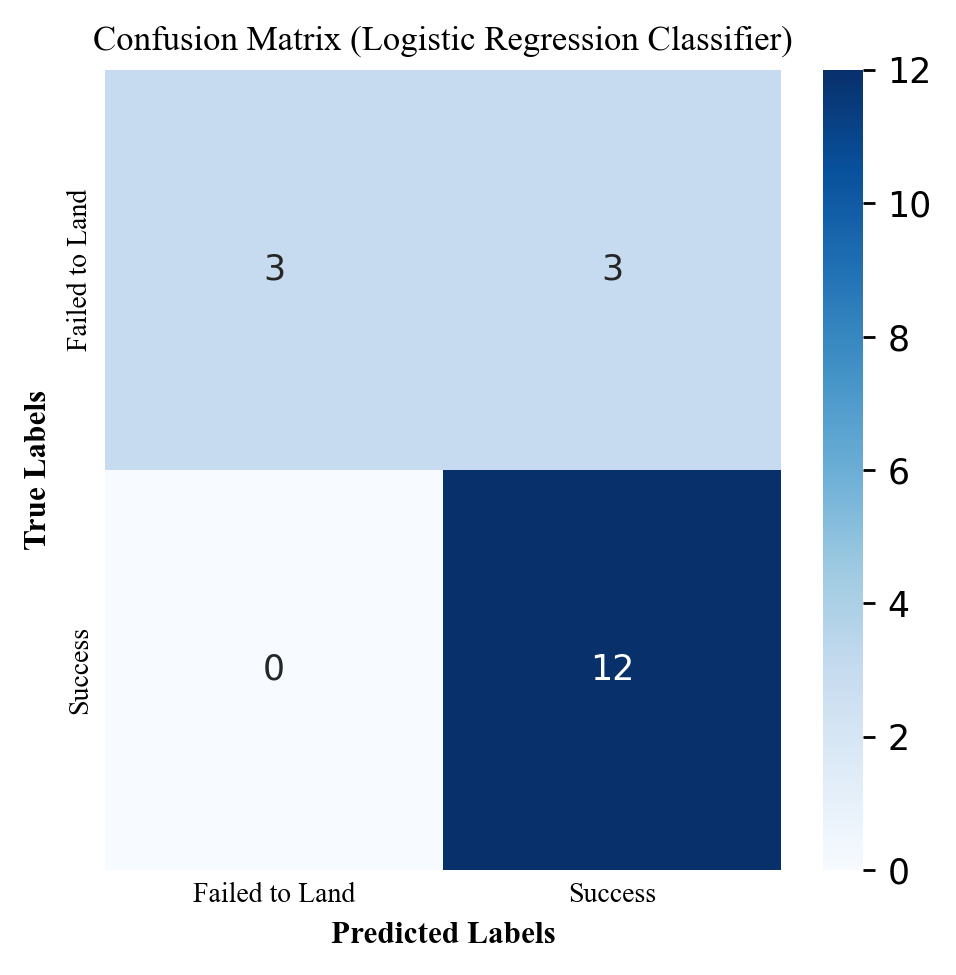

In [21]:
# predictions on Test set
yhat = logreg_cv.predict(x_test)

# confusion matrix
custom_confusion_matrix(y_true=Y_test, y_pred=yhat, normalize=False,
                        model_name="Logistic Regression Classifier")

#### Observation

$$\text{True Negatives}\;(C_{0,0}) = 3
\newline
\text{False Positives}\;(C_{0,1}) = 3
\newline
\text{False Negatives}\;(C_{1,0}) = 0
\newline
\text{True Positives}\;(C_{1,1}) = 12
\newline
$$

1. **False Positives** is a major problem. A better classifier is needed.

---

## TASK  6


Create a support vector machine object then  create a  <code>GridSearchCV</code> object  <code>svm_cv</code> with cv - 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [22]:
# SVM model instance
svm = SVC()

# hyperparameters for which best values are to be searched
parameters_grid_svm = {
    "kernel":["linear", "rbf", "poly", "sigmoid"],
    "C":np.logspace(start=-3, stop=3, num=5),
    "gamma":np.logspace(start=-3, stop=3, num=5)
}

# GridSearchCV instance
svm_cv = GridSearchCV(estimator=svm, param_grid=parameters_grid_svm, cv=10)

# fit GridSearchCV object to training set
svm_cv.fit(x_train, Y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']})

In [23]:
# best hyperparameter values
best_params_svm = svm_cv.best_params_
accuracy_svm_grid = svm_cv.best_score_

for param, value in best_params_svm.items():
    print(f"Best {param}: {value}\n")
print(f"Accuracy score for SVM with best found parameters: {accuracy_svm_grid}")

Best C: 1.0

Best gamma: 0.03162277660168379

Best kernel: sigmoid

Accuracy score for SVM with best found parameters: 0.8482142857142856


## TASK  7


Calculate the accuracy on the test data using the method <code>score</code>:


In [24]:
# accuracy of SVM model on test set
accuracy_svm_test = svm_cv.score(X=x_test, y=Y_test)

print(f"Test set Accuracy of SVM model with best found parameters: {accuracy_svm_test}")

Test set Accuracy of SVM model with best found parameters: 0.8333333333333334


We can plot the confusion matrix


Confusion Matrix (without normalization) ->
[[ 3  3]
 [ 0 12]]


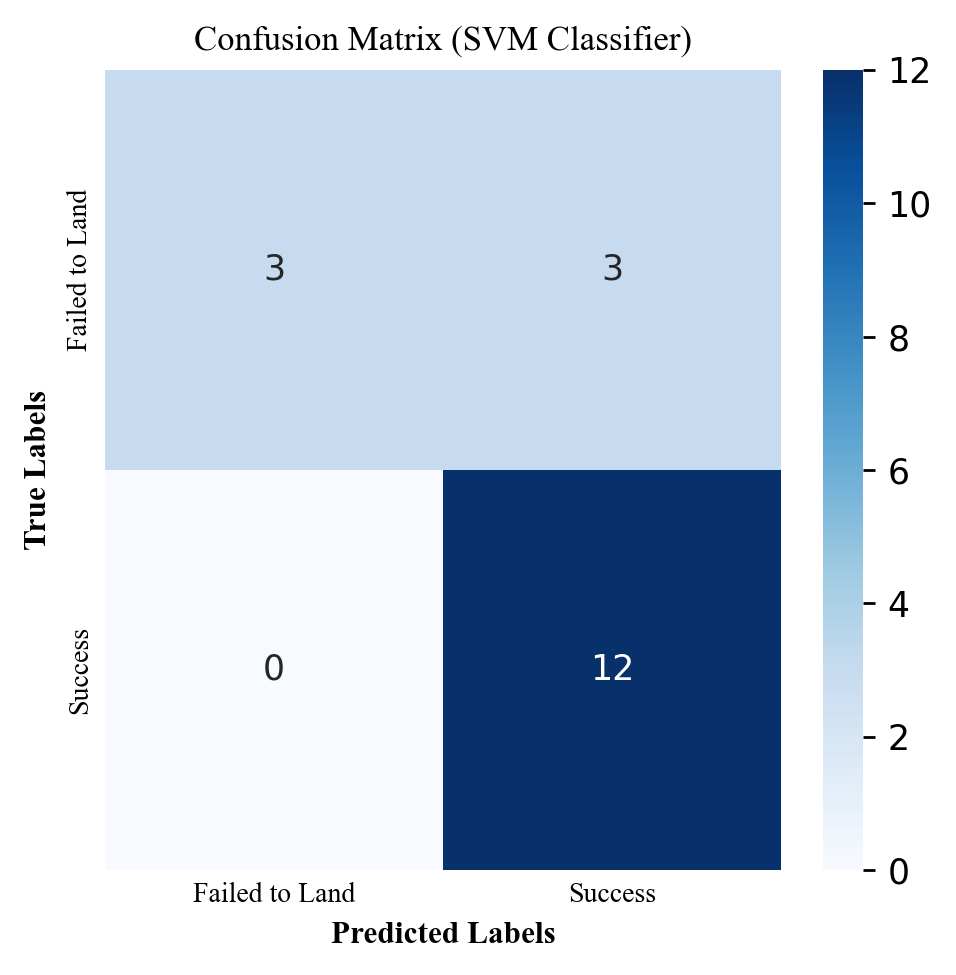

In [25]:
# predictions on Test set
yhat_svm = svm_cv.predict(x_test)

# confusion matrix
custom_confusion_matrix(y_true=Y_test, y_pred=yhat_svm, normalize=False,
                        model_name="SVM Classifier")

## TASK  8


Create a decision tree classifier object then  create a  <code>GridSearchCV</code> object  <code>tree_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [26]:
# Decision Tree classifier model instance
tree = DecisionTreeClassifier()

# hyperparameters for which best values are to be searched
parameters_grid_tree = {
    "criterion":["gini", "entropy"],
    "splitter":["best", "random"],
    "max_depth":[2*i for i in range(1,10)],
    "max_features":["auto", "sqrt"],
    "min_samples_leaf":[1, 2, 4],
    "min_samples_split":[2, 5, 10]
}

# GridSearchCV instance
tree_cv = GridSearchCV(estimator=tree, param_grid=parameters_grid_tree, cv=10)

# fit GridSearchCV object to training set
tree_cv.fit(x_train, Y_train)

C:\Users\rayjo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
3240 fits failed out of a total of 6480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3240 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\rayjo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\rayjo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\rayjo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\b

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [27]:
# best hyperparameter values
best_params_tree = tree_cv.best_params_
accuracy_tree_grid = tree_cv.best_score_

for param, value in best_params_tree.items():
    print(f"Best {param}: {value}\n")
print(f"Accuracy score for Decision Tree Classifier with best found parameters: {accuracy_tree_grid}")

Best criterion: gini

Best max_depth: 6

Best max_features: sqrt

Best min_samples_leaf: 1

Best min_samples_split: 2

Best splitter: random

Accuracy score for Decision Tree Classifier with best found parameters: 0.875


## TASK  9


Calculate the accuracy of tree_cv on the test data using the method <code>score</code>:


In [28]:
# accuracy of Decision Tree classifier model on test set
accuracy_tree_test = tree_cv.score(X=x_test, y=Y_test)

print(f"Test set Accuracy of Decision Tree Classifier model with best found parameters: {accuracy_tree_test}")

Test set Accuracy of Decision Tree Classifier model with best found parameters: 0.7777777777777778


We can plot the confusion matrix


Confusion Matrix (without normalization) ->
[[5 1]
 [3 9]]


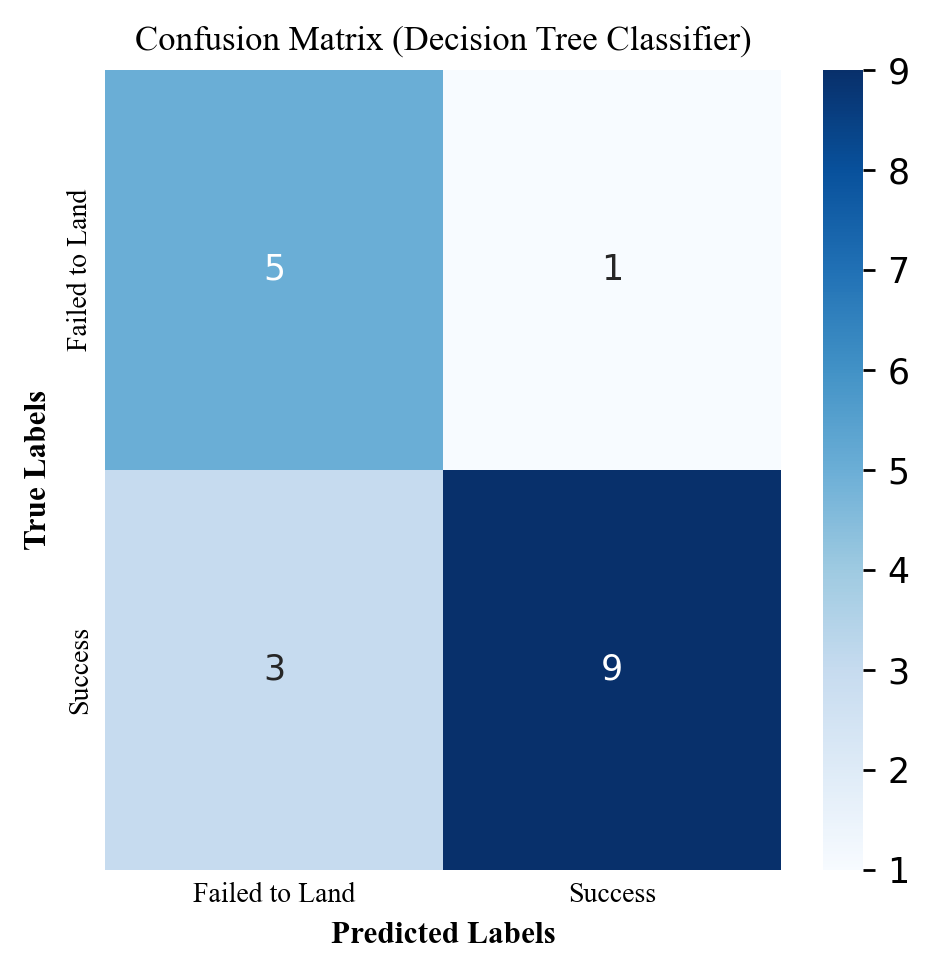

In [29]:
# predictions on Test set
yhat_tree = tree_cv.predict(x_test)

# confusion matrix
custom_confusion_matrix(y_true=Y_test, y_pred=yhat_tree, normalize=False,
                        model_name="Decision Tree Classifier")

---

## TASK  10


Create a k nearest neighbors object then  create a  <code>GridSearchCV</code> object  <code>knn_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [30]:
# KNN model instance
KNN = KNeighborsClassifier()

# hyperparameters for which best values are to be searched
parameters_grid_knn = {
    "n_neighbors":[i for i in range(1,11)],
    "algorithm":["auto", "ball_tree", "kd_tree", "brute"],
    "p":[1,2]
}

# GridSearchCV instance
knn_cv = GridSearchCV(estimator=KNN, param_grid=parameters_grid_knn, cv=10)

# fit to training set
knn_cv.fit(x_train, Y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [31]:
# best hyperparameter values
best_params_knn = knn_cv.best_params_
accuracy_knn_grid = knn_cv.best_score_

for param, value in best_params_knn.items():
    print(f"Best {param}: {value}\n")
print(f"Accuracy score for KNN Classifier with best found parameters: {accuracy_knn_grid}")

Best algorithm: auto

Best n_neighbors: 10

Best p: 1

Accuracy score for KNN Classifier with best found parameters: 0.8482142857142858


## TASK  11


Calculate the accuracy of knn_cv on the test data using the method <code>score</code>:


In [32]:
# accuracy of KNN classifier model on test set
accuracy_knn_test = knn_cv.score(X=x_test, y=Y_test)

print(f"Test set Accuracy of KNN Classifier model with best found parameters: {accuracy_knn_test}")

Test set Accuracy of KNN Classifier model with best found parameters: 0.8333333333333334


We can plot the confusion matrix


Confusion Matrix (without normalization) ->
[[ 3  3]
 [ 0 12]]


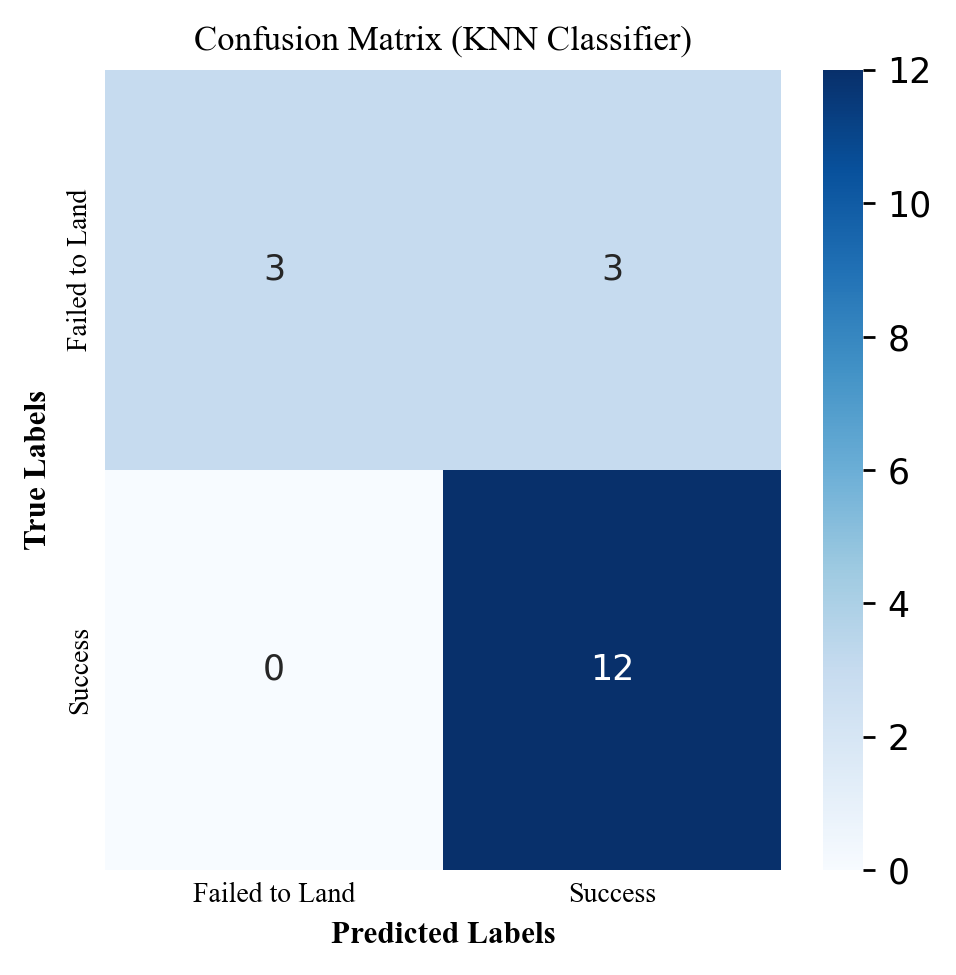

In [33]:
# predictions on Test set
yhat_knn = knn_cv.predict(x_test)

# confusion matrix
custom_confusion_matrix(y_true=Y_test, y_pred=yhat_knn, normalize=False,
                        model_name="KNN Classifier")

## TASK  12


Find the method performs best:


In [34]:
# test set accuracy of models
accuracy_dict ={
    "Logistic Regression":accuracy_lr_test,
    "SVM":accuracy_svm_test,
    "Decision Tree":accuracy_tree_test,
    "KNN":accuracy_knn_test
}

# test set accuracy dataframe
accuracy_df = pd.DataFrame(data=accuracy_dict, index=["Test set Accuracy"])

accuracy_df

,Logistic Regression,SVM,Decision Tree,KNN
Test set Accuracy,0.833333,0.833333,0.777778,0.833333


In [35]:
# save test classification accuracy as csv
accuracy_df.to_csv(r"D:\IBM Professional Certification\10_Data Science Capstone Project\7_ML Model building\8_ML Model building\data\accuracy_2.csv")